<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Chapters%20Notebooks/Other_Computer_Vision_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Run once

!pip install fastai --upgrade

     |████████████████████████████████| 194kB 15.1MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 243kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
# Certain utils

#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()
#from fastbook import *

# Needed packages

from fastai import *
from fastai.vision.all import *
import fastai 
print(fastai.__version__)

2.3.0


In this chapter will look into two other types of Computer Vision Problems: 

* Multi - Label Classification
* Regression 

The first one occurs when you want to predict more than one label per image, for instance predict a dog and a cat in a same image. 

The second one occurs when the labels are one or several numbers, a quantity instead of a category. And will also learn about output activations , targets and loss functions in DL models 

## Multi - Label Classification

Multi - Label Classification refers to a problem of identifying the categories of objects in a images that may not contain exactly same type of object, or there may be no objects at all in the class we are looking for. 

For instance so far in our Image Classifier, whenever we input a image which is not of the classes our model would still point out that belongs to the same class with low confidence. For instance in Dog Bree Classifer what if you input a picture of horse? 

Well our model will return that its some kinda of dog breed but in reality we do know that isn't. But with multi - label classification we can solve this issue with our classifiers! 

In practice it's common to have some images with the zero matches or more than one match, we should probably expect in practice multi - label classifiers are more widely applicable than single label classifiers.

Here the architecture remains the same but our loss function would change. 

### The Data 

In this example we are going to use the `PASCAL` dataset, which can have more than one kind of classifed object per image. 

This data would be different from the ones we have seen before, in that it's not structured by filename or folder but instead comes with a CSV telling us the labels to use for each image

In [ ]:
# Getting the data 

path = untar_data(URLs.PASCAL_2007)

In [ ]:
# Using pandas to read the csv file 

import pandas as pd 
df = pd.read_csv(path/'train.csv')
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


### Constructing the DataBlock

We have a DataFrame object how do we convert this into a DataLoaders object? We usually build a datablock and with that create a DataLoaders object. Here in this tutorial will go step by step to build a DataBlock! 

#### **Dataset** 
A collection that returns a tuple of the independet and dependent variable for a single item. 

#### **DataLoader** 
An iterator that provides a stream of mini-batches, where each mini-batch is a pair of a batch of independent variables and a batch of dependet variables.

On top of these fastai brings two classes for bringing the training and validation sets together. They are called `Datasets` and `DataLoaders`.

#### **Datasets**
An iterator that contains a training Dataset and validation Dataset --> tuple of independent and dependent variable for both train and valid set. 

#### **DataLoaders**
An object that contains a training DataLoader and a validation DataLoader. 

Since the DataLoader is built on top of a Dataset and adds additional functionality to it, (collating multiple items into a mini-batch). It's often easier to start by creating and testing `Datasets`, and then look at `DataLoaders` after that's working.

Let's start creating from scratch!!!

In [ ]:
# Creating a empty datablock
dblock = DataBlock()

Now we can create a `Datasets` object from this, the only thing we need is a **source** in our case -- **DataFrame**

And this will have train and validation dataset, which we can index into

In [ ]:
# Creating a datasets -- with a source 

dsets = dblock.datasets(df)
dsets[0:5]

[(Pandas(Index=0, fname='000005.jpg', labels='chair', is_valid=True),
  Pandas(Index=0, fname='000005.jpg', labels='chair', is_valid=True)),
 (Pandas(Index=1, fname='000007.jpg', labels='car', is_valid=True),
  Pandas(Index=1, fname='000007.jpg', labels='car', is_valid=True)),
 (Pandas(Index=2, fname='000009.jpg', labels='horse person', is_valid=True),
  Pandas(Index=2, fname='000009.jpg', labels='horse person', is_valid=True)),
 (Pandas(Index=3, fname='000012.jpg', labels='car', is_valid=False),
  Pandas(Index=3, fname='000012.jpg', labels='car', is_valid=False)),
 (Pandas(Index=4, fname='000016.jpg', labels='bicycle', is_valid=True),
  Pandas(Index=4, fname='000016.jpg', labels='bicycle', is_valid=True))]

In [ ]:
# Indexing into train set! 

dsets.train[5] # first set in train

(fname       007954.jpg
 labels             dog
 is_valid          True
 Name: 4010, dtype: object, fname       007954.jpg
 labels             dog
 is_valid          True
 Name: 4010, dtype: object)

It's a bit confusing here why it's been printed out two times? Well thats by default, the datablock assumes we have two things: 
* Input
* Target

But we don't need all this shit, so we are going to grab the appropriate fields from the DataFrame, which we can do by passing `get_x` and `get_y` function.

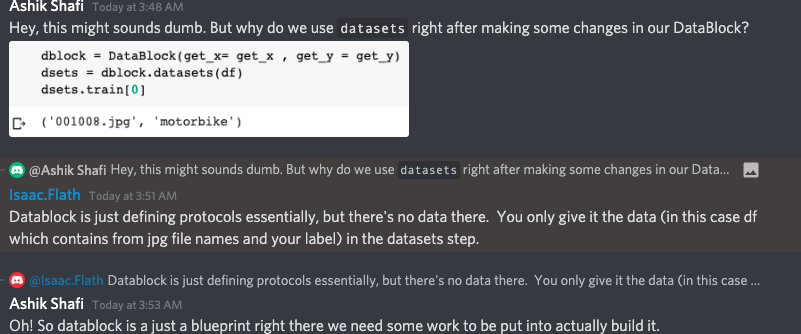

In [ ]:
# Getting the x and y 

# dblock = DataBlock(get_x= lambda r:r['fname'] , get_y= lambda r:r['labels'] )

# Creating a function for getting y and x 

def get_x(r): return r['fname']

def get_y(r): return r['labels']

dblock = DataBlock(get_x= get_x , get_y = get_y) 
dsets = dblock.datasets(df)
dsets.train[5]

('004748.jpg', 'aeroplane car')

But the independent variable (x) will need to be converted into a complete path, so that we can **open it as an image**, and the dependent variable should be split on the space character. Because they are tied together but in reality they are two different objects. 

In [ ]:
# Making changes in get x and y 

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

# Creating the datablock and dsets again 

dblock = DataBlock(get_x = get_x , get_y = get_y)
dsets = dblock.datasets(df)

# Now looking into 
dsets.train[5]

(Path('/root/.fastai/data/pascal_2007/train/005645.jpg'), ['car', 'person'])

Alrighty! We got the path now but how do we open the images and do conversion on tensors? 

For this we need to use a set of transforms, block types will provide us with those transforms. The blocks we have seen so far are `ImageBlock` and `CategoryBlock`sure we can use the same but with one exception. We can't use the `CategoryBlock` in this problem, well it expects for only a single integer but in our case we need to have multiple labels for each item. 

To solve this we use `MultiCategoryBlock`, this can expects to recieve a list of strings as have in this case. 

In [ ]:
# Using the Blocks 

dblock = DataBlock(blocks=(ImageBlock , MultiCategoryBlock) , get_x= get_x , get_y= get_y) # a blueprint 
dsets = dblock.datasets(df)
dsets.train[5]


(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

If we take a look, the list of categories is not encoded in the same way that it was for the regular `CategoryBlock`, well in that case we had a single integer representing which category was present. 

For instance is it a cat? (or) is this an abyssinian cat? 

In that case we had a list of `0s` with a `1` in any position where that category is present.

In here if there is a `1` in the second and fourth positions, that means vocab items two and four are present in this image. This is known as one-hot encoding. 

The reason we can't easily just use a list of category indices is that each list would be of different length, and Pytorch requires tensors, where everything has to be same length.

In [ ]:
# Checking the categories 

idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#3) ['chair','diningtable','person']

With Numpy arrays and Pytorch Tensors and fastai's L class we can index directly using a list or vector. 

For now we have ignored the column `is_valid` up until now, which means that DataBlock has been using a random split by default. To choose the elements of our validation set, we need to write a function and pass it to splitter. 

It will take the items (in here our whole DataFrame) and must return two (or more) list of integers.

In [ ]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train , valid

In [ ]:
df['is_valid'].value_counts()

True     2510
False    2501
Name: is_valid, dtype: int64

In [ ]:
dblock = DataBlock(blocks = (ImageBlock , MultiCategoryBlock),  
                   splitter = splitter , 
                   get_x = get_x , 
                   get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[4]

(PILImage mode=RGB size=500x281,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

As we discussed a `DataLoader` collates the items from a Dataset into a mini-batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the Dataset item. 

Now we gotta make sure every item is of same size before putting them into a `DataLoaders`, we use `RandomResizedCrop`.

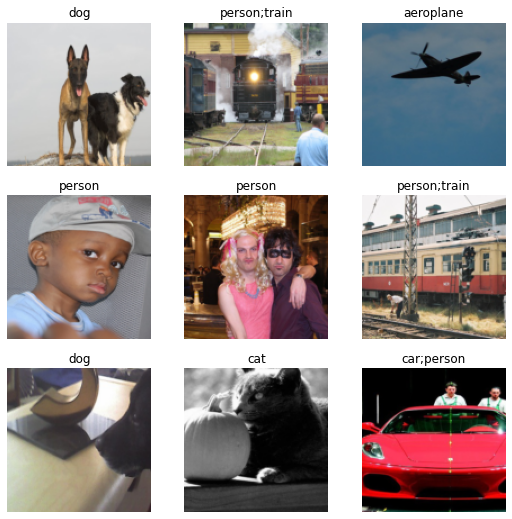

In [ ]:
dblock = DataBlock(blocks=(ImageBlock , MultiCategoryBlock) , 
                   splitter = splitter , 
                   get_x = get_x , 
                   get_y = get_y , 
                   item_tfms = RandomResizedCrop(128 , min_scale=0.353))

# Putting into a Dataloader
dls = dblock.dataloaders(df)

# Displaying a sample of our data
dls.show_batch()

There wasn't much a change instead we built the `DataBlock` from scratch and used a `MultiCategoryBlock` instead of the `CategoryBlock`. As we know the DataLoader collates the items from a Dataset into a mini-batch. 

Our data is now ready for the model, nothing is going to change even with the `Learner` but this time we are going to use a new Loss Function, which is called **Binary Cross Entropy**.

### **Binary Cross Entropy**

As we saw in the previous chapter the `Learner` object contains four main things : 

- The Model
- `DataLoaders` object
- An `Optimizer`
- A Loss Function to use

We already have our `DataLoaders` and leverage fastai's resnet models and we know how to create a **SGD Optimizer**, now we gotta make sure whether we are having a suitable loss function. 

Using `cnn_learner` creating a Learner and checking out the activations. And we know `Learner` is generally an object of a class inheriting from `nn.Module` and we can return the activations of our model.

We can grab a mini-batch from our `DataLoader` object and then passing into the model. 

Putting everything into code, 


In [ ]:
# Creating a learner to check out the acitvations 

learn = cnn_learner(dls , resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# Getting the activations from the DataLoader object 

x,y = to_cpu(dls.train.one_batch()) # using CPU for this operation
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
# Checkin what device we are running on 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Well in the `torch.Size([64, 20])` we have a batch size of 64, and we need to calculate the probability of each categories. Let's check how the one of the activations looks like,

> Knowing how to manually get a mini_batch and pass it into a model, and look at the activations and loss is really a important for debugging our model. 

In [ ]:
activs[4] # For the first item in a batch. 4 / 64, ea

tensor([-2.3705,  1.9720, -1.4935, -1.0476, -0.8454,  2.3756,  0.2739,  1.7685,
        -0.5710, -0.5354, -0.3776, -0.7400,  1.5046, -0.4159, -0.8391, -0.2559,
        -0.1988, -0.0862,  0.9077,  0.8166], grad_fn=<SelectBackward>)

So above we got a whole bunch of array of tensors, well there are 20 categories in there, and `64` items in our one batch. Each item has 20 probabilities. 

If we look closely, those values aren't scaled between 0 to 1, but we can by using a sigmoid function. We can also calculate the loss by using a `log_loss`.

In [ ]:
# Something like this

def binary_cross_entropy(inputs , targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets ==1, inputs , 1-inputs).log().mean()

Well if we are going to use the above function, we will run into a similar error like this below, 

**`TypeError: no implementation found for 'torch.where' on types that implement __torch_function__: [TensorMultiCategory, TensorImage]`**

Here in this problem we have **one-hot-encoded** dependent Variables (y), so we can't directly use `nll.loss` or `softmax` in simple words we can't use `cross_entropy`. 

Let's breaking things down why we can't we directly use `nll.loss` or `softmax`, 

-  **`softmax`**, as we saw it requires that all predictions sum to **1**, and tends to push one activations to be much larger than the others. And in our case we have multiple objects that we're confident appear in an image, so **restricting the maximum sum of activations to 1** is not a good idea. By the same reasoning, we may want the sum to be less than 1, if we don't think any of the categories appear in an image. 

- **`nll_loss`**, as we it returns the value of just one activations, which means the **single activations corresponding with the single label for an item**. But it doesn't make sense when we have multiple labels. 


On the other hand `binary_cross_entropy` function, which is just `mnist_loss` but along with **log.** provides just what we need, with Pytorc's element wise operations. Each activations will be compared to each target for each column, so we don't wanna do much to work this for multiple columns. 

Pytorch already provides us with this function, in fact it provides with a number of versions, with rather confusing names. 

`F.binary_cross_entropy` and its module equivalent to *==* `nn.BCELoss` which calculate cross entropy on a one-hot-encoded target, but do not include the initial **sigmoid**. 

Normally for one-hot-encoded target's we will want `F.binary_cross_entropy_with_logits` (or `nn.BCEWwithLogitLoss`), which do the both **sigmoid** and **binary cross entropy** in a single function.

Whereas in our previous example, for single label datasets (PETs and MNIST), where the target is encoded as a single integer, `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax. 


So when we have one-hot-encoded target we will use `BCEWithLogitLoss. `

In [ ]:
# Calculting using the BCEWithLogitLoss

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs , y) # activations and targets 
print(f'The loss for one batch is: {loss}')

The loss for one batch is: 1.0578525066375732


Fastai will able to choose the loss function for us even if we didn't mention it. By looking at our `DataLoaders` having multiple category labels, so it will use `nn.BCEWithLogitLoss` by default. 

One change we would be making to the preceding chapter is the metric we use, well because this is a multi-label problem and we can't use the accuracy function. Well because, 

In [ ]:
# The normal accuracy (For Single Label)

def accuracy(inp , targ , axis=1): 
  '''
  Compute accuracy with `targ` when `pred` is (bs * no.of classes)
  '''
  pred = inp.argmax(dim = axis)
  return (pred == targ).float().mean()

Breaking for understanding how the above thing works! 

In [ ]:
dum_pred = activs.argmax(dim = 1) # 4th index of the array has highest probability
dum_pred

tensor([ 4,  4, 12, 12,  5, 10, 15,  7, 16,  9, 16, 16,  3,  2, 16, 19,  1, 16,
        14,  4, 16,  0,  7, 14,  6, 13, 18, 14,  0,  7, 14,  2,  8, 10,  8,  2,
         7,  3, 10,  9,  4,  4, 18, 10,  7, 19,  5,  8, 12, 10, 18, 12,  7, 11,
        11, 13, 12,  9, 10, 18,  6, 13,  2, 19])

In [ ]:
activs[0] # We can see the value  3.7935 has highest probability

tensor([-2.6251,  1.2700, -3.0856,  0.2241,  2.6364,  0.8470, -0.1612, -0.9613,
        -1.5950,  0.5609, -0.3519, -0.0427,  0.5007,  0.8655,  2.2188, -1.7701,
        -1.8720, -0.0058,  2.5797, -1.9792], grad_fn=<SelectBackward>)

In [ ]:
# Comparing with targets 
# dum_pred == y)

In [ ]:
# Checkin the dimension 

dum_pred.shape , y.shape # We need multiple columns of probabilties!

(torch.Size([64]), (64, 20))

The class predicted was the one with highest activation, here it doesn't work because we could have more than one prediction on a single image (Cat Person). After applying the **sigmoid** to our activations (to make them between 0 to 1) we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. 

Each value above the *threshold* will be considered as 1, and lower value considered as 0. 



In [ ]:
# accuracy_multi??

In [ ]:
# Constructing accuracy for multi label problems 

def accuracy_multi(inp , targ , thresh=0.5 , sigmoid=True):
  "Compute accuracy when `inp` and `targ` are the same size."
  if sigmoid:
    inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()

Breaking down by code blocks

In [ ]:
multi = activs.sigmoid()
multi[0] # But if we add that doesn't add upto 1 

tensor([0.0675, 0.7807, 0.0437, 0.5558, 0.9332, 0.6999, 0.4598, 0.2766, 0.1687,
        0.6367, 0.4129, 0.4893, 0.6226, 0.7038, 0.9019, 0.1455, 0.1333, 0.4985,
        0.9295, 0.1214], grad_fn=<SelectBackward>)

In [ ]:
# Using a threshold to decide btw 0 and 1 

thresh = 0.5
thre_1_batch = (multi > thresh)[0] 
thre_1_batch

tensor([False,  True, False,  True,  True,  True, False, False, False,  True,
        False, False,  True,  True,  True, False, False, False,  True, False])

In [ ]:
# Comparing with targets 

pred_multi = (thre_1_batch) == (y[0].bool())
pred_multi

TensorMultiCategory([ True, False,  True, False, False, False, False,  True,  True, False,
         True,  True, False, False, False,  True,  True,  True, False,  True])

In [ ]:
# Returns the accuracy in single integer!! 
pred_multi.float().mean()

TensorMultiCategory(0.5000)

In [ ]:
# Doing for the one whole batch now 

acc_mult = accuracy_multi(activs , y , thresh=0.5)
acc_mult # Accuracy for one batch

TensorMultiCategory(0.5063)

If we pass `accuracy_multi` directly as a metric, it will use default value for thresh which **0.5**, we can use *partial* a Python function. Which re-creates the function with a newer version where we can make some changes in the arguments or key word arguments, and making a new version of that funciton. 

In [ ]:
# For instance,

def say_hello(name , say_what = 'Hello'):
  return f'{say_what} {name}'
say_hello('Ashik')

# Trying to overwrite the function 
say_hello(say_what='Yo' , name = 'Ashik')

'Yo Ashik'

In [ ]:
# Using Partial 

f = partial(say_hello , say_what = 'Yo')
f('Ashik')

'Yo Ashik'

We can now train the model, using partial to set the threshold! 

In [ ]:
# Creating a learner and fitting it

learn = cnn_learner(dls , resnet18 , metrics=partial(accuracy_multi , thresh = 0.2))
learn.fine_tune(3 , base_lr=3e-3 , freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.992383,0.746316,0.186594,00:26
1,0.875493,0.583172,0.224163,00:26
2,0.647195,0.218974,0.793526,00:26
3,0.393075,0.143023,0.932550,00:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.153334,0.129216,0.937331,00:26
1,0.136444,0.119722,0.943845,00:26
2,0.121145,0.118946,0.942510,00:26


Picking a threshold is important. If we pick a threshold that's too low, we will often be failing to select correctly labeled objects. 

if we pick a threhold that's too high, we will be selecting only object's which the model is very confident about. 

We can find the best threshold by trying a few levels and seeing what work's best. This is much faster if we grab **predictions** just once. 

In [ ]:
# Lowering the threhold 

learn.metrics = partial(accuracy_multi , thresh = 0.1)
learn.validate() # returns validation loss and metrics

(#2) [0.11894604563713074,0.9151594638824463]

In [ ]:
# Increaing the threshold 

learn.metrics = partial(accuracy_multi , thresh = 0.99)
learn.validate() # returns validation loss and metrics

(#2) [0.11894604563713074,0.9366136193275452]

In [ ]:
# Finding the best threshold 

preds , targs = learn.get_preds()

In [ ]:
preds[0] , targs[0]

(tensor([0.0048, 0.0063, 0.0029, 0.0016, 0.0381, 0.0029, 0.0053, 0.0201, 0.7640,
         0.0042, 0.2886, 0.0106, 0.0020, 0.0020, 0.1351, 0.1345, 0.0027, 0.1298,
         0.0020, 0.2457]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

So after getting the predictions and targets, now we will call the metric directly. But in here we will turn `sigmoid = False`. 

It's because when we call `get_preds` it applies the output activation function (sigmoid) by default, we will tell `accuracy_multi` not to apply it.

In [ ]:
# Setting sigmoid to false 

accuracy_multi(preds , targs , thresh=0.5 , sigmoid=True)


TensorMultiCategory(0.0776)

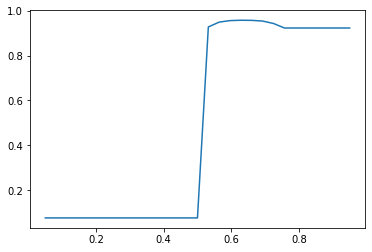

In [ ]:
# Using this approach to find the best threshold level

xs = torch.linspace(0.05 , 0.95 , 29)
accs = [accuracy_multi(preds , targs , thresh=i , sigmoid=True) for i in xs]
plt.plot(xs , accs)

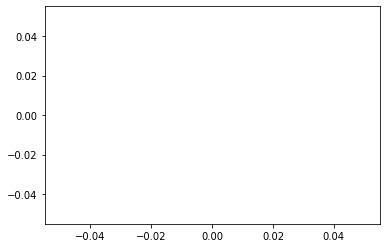

In [ ]:
xs = torch.linspace(0.05 , 0.95 , 29)
accs = [accuracy_multi(preds , targs , thresh=i , sigmoid=False) for i in xs]
plt.plot(xs , accs)

In [2]:
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 16.7MB/s 
     |████████████████████████████████| 12.8MB 194kB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
from fastai.vision.all import * 
from fastai import * 
import fastai 
print(fastai.__version__)

2.3.0


## Regression 

A model is defined by it's independent and dependent variables, along with it's loss function. 

That tmeans that there's really a far wider array. In here we have a, 
- Independent variable that's an image, and a dependent that's text (e.g. generating a caption from an image), or 
- perhaps we have an independent variable that's text, and dependent that's an image (e.g generating an image from caption - which is actually possible for deep learning to do.)
- Or we've got images, texts, and tabular data as independent variables and we're trying to predict product purchases and the possibilities goes on....


> To craft our own novel solutions to novel problems, it helps to really uderstand the data block API (even the mid-tier API). 

Now we will deal with Image Regression, this refers: 
- **Learning form a dataset in which the independent variable is an image, and the dependent variable is one or more floats.** 

#### What's key point model
A key point refers to a specific location represented in an image - in this case, we'll use images of people and we'll be looking for the center of the person's face in each image. 

That means actually **predicting two values** for each image, the row and columns of the face center. 

### Assembling the Data 
We'll use the  [**Biwi Kinect Head pose dataset**](https://oreil.ly/-4cO-) 

In [2]:
# Downloading the dataset 
path = untar_data(URLs.BIWI_HEAD_POSE)

# What's inside the dataset we downloaded? 
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/15.obj'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/11'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/08.obj')...]

**What's inside**? 
- There are *24 directories* numbered from 01 - 24 (corresponded to different people photographed). 
- And a corresponding `.obj` file for each (we won't need them now). 

In [3]:
# Looking into one of the directories 
(path/'02').ls()

(#1024) [Path('/root/.fastai/data/biwi_head_pose/02/frame_00013_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00036_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00145_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00417_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00346_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00031_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00324_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00169_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00038_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/02/frame_00035_rgb.jpg')...]

- Inside the sub-directories , we have different frames. 
  - Each comes with an image `(_rgb.jpg)` and a pose file (_pose.txt). 

We can easily get all images by using `get_image_files` and then write a **function that converts an image file name to it's associated pose file**

In [4]:
# How many files in here?
import os 
print(len(os.listdir(path/'02')))

1024


In [5]:
path

Path('/root/.fastai/data/biwi_head_pose')

In [6]:
# Getting the image files 
img_files = get_image_files(path)
img_files

(#15678) [Path('/root/.fastai/data/biwi_head_pose/24/frame_00036_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00031_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00324_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00038_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00035_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00400_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00281_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00422_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00053_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/24/frame_00229_rgb.jpg')...]

In [7]:
# Function to convert image file name to pose.txt file 
def image2pose(x):
  return Path(f'{str(x)[:-7]}pose.txt')


In [8]:
# Image file name 
img_files[0]

Path('/root/.fastai/data/biwi_head_pose/24/frame_00036_rgb.jpg')

In [9]:
# Using the above function by passing a image filename
image2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/24/frame_00036_pose.txt')

In [10]:
# Looking at our first image 
im = PILImage.create(img_files[0])
im.shape


(480, 640)

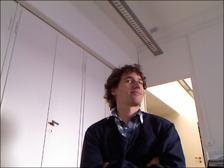

In [11]:
im.to_thumb(224)

Understanding about the Biwi dataset, explains the format of the pose txt file associated with each image. Which shows the **location of the center of the head**.

So now we need a function to extract the head center point. 



In [12]:
# How one of the file looks like?
cal = np.genfromtxt(path/'01'/'rgb.cal' , skip_footer= 6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [13]:
# Function which grabs the points which localize the center of head 
def get_ctr(f):
  ctr = np.genfromtxt(image2pose(f) , skip_header= 3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1 , c2])

In [14]:
# This function returns the coordinates as a tensor of two items 
get_ctr(img_files[0])

tensor([401.1082, 239.5933])

Now we can pass this function `get_ctr` to `get_y`, since it's responsible for labelling each item. 

We can't use `RandomSplitter` in here because, same people appear in multiple images in this dataset but we gotta make sure that our model generalizes well. 

To tackle this, we could write our own splitter function which returns **True** for just one person, resulting in a validation set containing just that person's images. 

Another changes would be on the **blocks** where the second block will be an `PointBlock`. This is necessary so that fastai knows that the **labels respresent coordinates,** that way, it knows that when doing data augmentation, it should do the same augmentation to tese coordinates as it does to the images. 

In [15]:
# Building a DataBlock 
biwi = DataBlock(
    blocks = (ImageBlock , PointBlock), 
    get_items = get_image_files , 
    get_y = get_ctr, 
    splitter = FuncSplitter(lambda o: o.parent.name == '13'), 
    batch_tfms = [*aug_transforms(size = (240 , 320)) , 
                  Normalize.from_stats(*imagenet_stats)]
)

# Getting the datablock summary 
biwi.summary(path)

Setting-up type transforms pipelines
Found 15678 items
2 datasets of sizes 15193,485
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_ctr -> TensorPoint.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/biwi_head_pose/24/frame_00036_rgb.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: get_ctr -> TensorPoint.create
    starting from
      /root/.fastai/data/biwi_head_pose/24/frame_00036_rgb.jpg
    applying get_ctr gives
      tensor([401.1082, 239.5933])
    applying TensorPoint.create gives
      TensorPoint of size 1x2

Final sample: (PILImage mode=RGB size=640x480, TensorPoint([[401.1082, 239.5933]]))


Found 15678 items
2 datasets of sizes 15193,485
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_ctr -> TensorPoint.create
Setting up after_item: Pipeline: PointScaler -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div'

In [16]:
# This is how splitter works 
img_files[0].parent.name 

'24'

> **Note:** In Fastai the augmentations are automatically applied to coordinates. So if we are working with another library we may need to disable data augmentation for these kind of problems. 

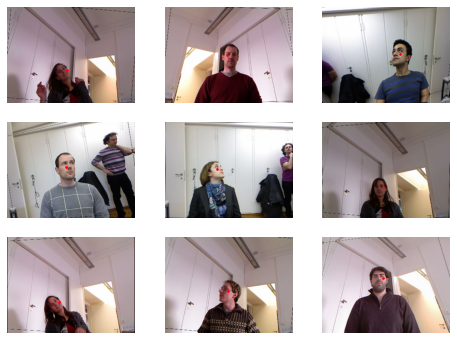

In [17]:
# Putting them into dataloaders for producing mini-batches of (train,valid)
dls = biwi.dataloaders(path)

# Looking into our data after all done 
dls.show_batch(max_n= 9 , figsize = (8 , 6))

In [18]:
# Let's check what our model is really seeing 
xb , yb = dls.one_batch()

print(f'Samples: {xb.shape}')
print(f'Labels: {yb.shape}')

Samples: torch.Size([64, 3, 240, 320])
Labels: torch.Size([64, 1, 2])


In [19]:
# How does the one row from dependent variable looks like? 
yb[0]

TensorPoint([[-0.2261,  0.0208]], device='cuda:0')

All we did is label the data and tell fastai what kind of data that independent and dependent variable represent. 

### Training a Model 

We gotta use `y_range` to tell fastai the range of our targets, where coordinates in fastai and Pytorch are always re-scaled between -1 to 1. 

`y_range` is implemented in fastai using the `sigmoid_range`, which is defines as: 



```
def sigmoid_range(x , lo , hi): 
  return torch.sigmoid(x) * (hi-lo) + lo
```
This is set as the final layer of the model, if `y_range` is defined. This function forces the model to output activations in the range (lo , hi). 

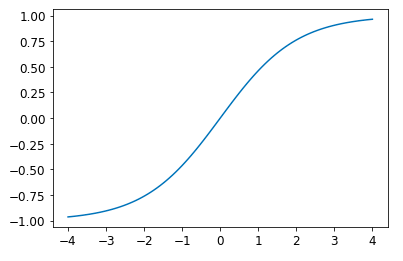


In [20]:
# Creating an model 
learn = cnn_learner(dls , resnet18 , y_range=(-1 , 1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [21]:
# What loss function our model picked in default? 
learn.loss_func

FlattenedLoss of MSELoss()

Our loss is `MSELoss()` because we are using coordinates as our dependent variable, most of the time we're likely to be predicting something as close as possible, that's basically what MSELoss (mean squared error loss) does.

Also `MSELoss` is already useful metric for this task, it's probably most interpretable after we take the square root. 

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.0964781722577754e-06)

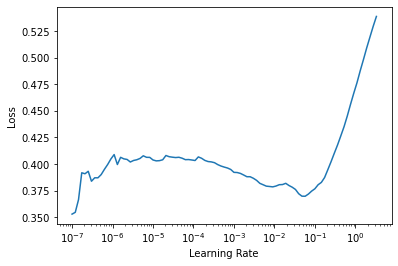

In [22]:
# Picking a learning rate 
learn.lr_find()

In [23]:
# Training our model 
lr = 2e-2
learn.fit_one_cycle(5 , lr)

epoch,train_loss,valid_loss,time
0,0.041528,0.004661,01:56
1,0.006585,0.001225,01:56
2,0.002991,0.003103,01:56
3,0.001986,0.000650,01:56
4,0.001582,0.000182,01:56


In [25]:
math.sqrt(0.000182)

0.013490737563232042

#### Let's look at the results 
By calling `learner.show_results()` our results will be plotted out, the **left side has the actual (ground truth) coordinates and right side our model's prediction.**

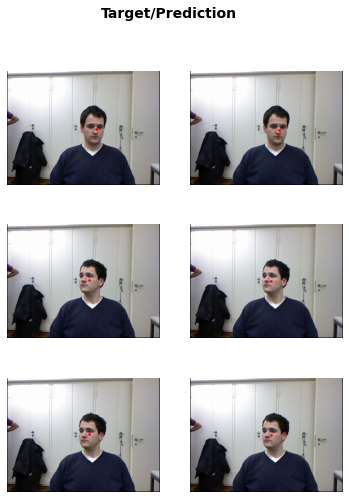

In [27]:
learn.show_results(ds_idx= 1 , max_n= 3 , figsize = (6 ,8))